In [123]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import random
random.seed(56)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from datetime import datetime as dt
from sklearn.model_selection import StratifiedKFold

import lightgbm
import optuna
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

## Dataset

In [185]:
# 학습 데이터
train = pd.read_csv('./train.csv')
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
* Y_Quality : 제품 품질 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [211]:
# 검증 데이터
test = pd.read_csv('./test.csv')
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [187]:
# 제출 양식
subm = pd.read_csv('./sample_submission.csv')
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

### astype

In [188]:
train.dtypes

PRODUCT_ID     object
Y_Class         int64
Y_Quality     float64
TIMESTAMP      object
LINE           object
               ...   
X_2871        float64
X_2872        float64
X_2873        float64
X_2874        float64
X_2875        float64
Length: 2881, dtype: object

In [189]:
train['LINE'] = train['LINE'].astype('category')
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')

### Y Class & Y Quality

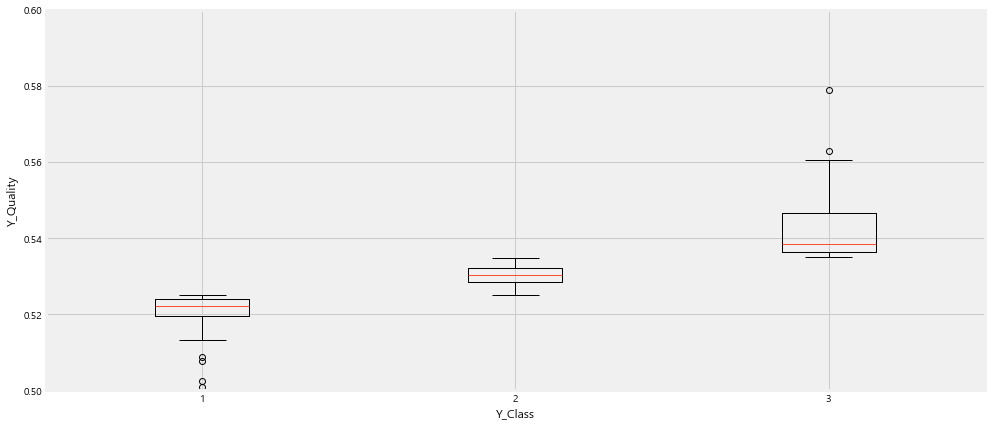

In [190]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots()

ax.boxplot([train[train['Y_Class']==0].Y_Quality, train[train['Y_Class']==1].Y_Quality, train[train['Y_Class']==2].Y_Quality])
ax.set_ylim(0.5, 0.6)
ax.set_xlabel('Y_Class')
ax.set_ylabel('Y_Quality')
plt.show()

In [191]:
# Class는 Quality를 3등분한 결과
for i in range(3):
    tmp = train[train['Y_Class']==i].Y_Quality
    print(f'Class : {i}, Quality range : {min(tmp)} ~ {max(tmp)}')

Class : 0, Quality range : 0.500855556 ~ 0.525066667
Class : 1, Quality range : 0.525085714 ~ 0.534842857
Class : 2, Quality range : 0.534950794 ~ 0.57884127


In [192]:
train.Y_Class.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

### Product Code value counts

In [193]:
# Product Code는 3가지로 이루어져 있다.
train['PRODUCT_CODE'].value_counts()

T_31    343
A_31    249
O_31      6
Name: PRODUCT_CODE, dtype: int64

### Line value counts

In [194]:
# Line은 6가지
train['LINE'].value_counts()

T100304    175
T100306    174
T050304     78
T010306     70
T010305     59
T050307     42
Name: LINE, dtype: int64

### TimeStamp

* 일, 시, 분 단위 모두 연속적이지 않으므로 활용할 수 없다. interpolate(보간)을 하기에도 너무 공백이 많다.
* 단 월 단위는 quality의 감소세가 확인된다.

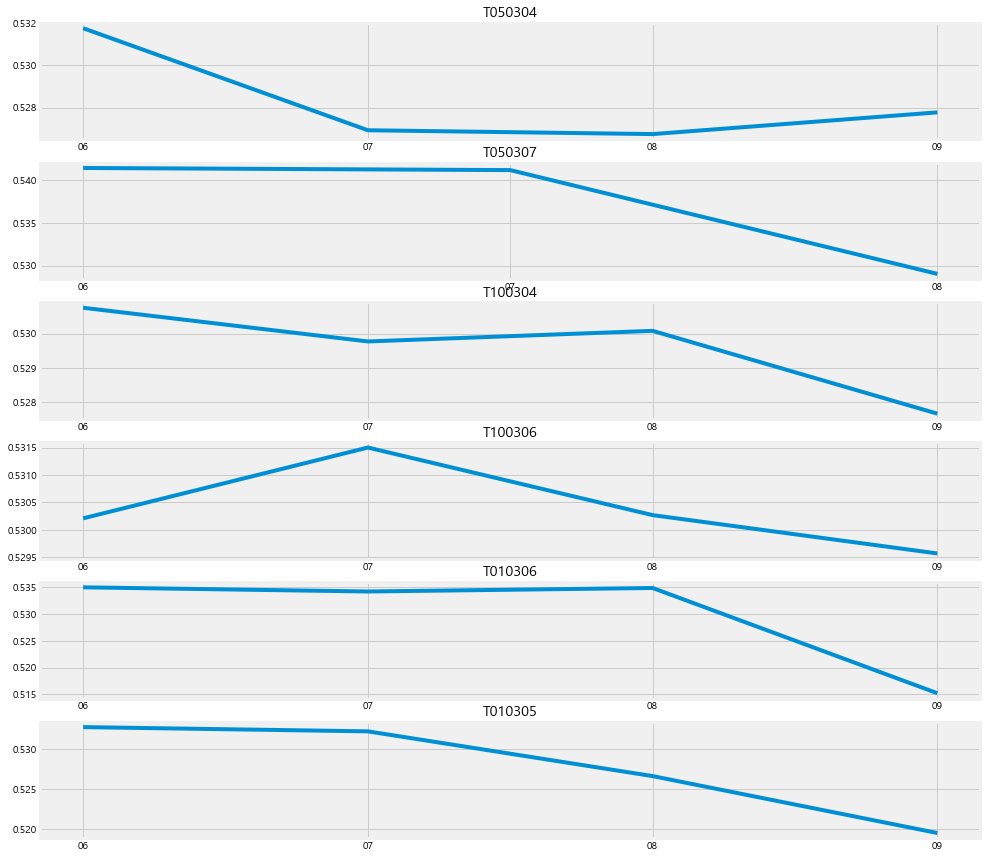

In [195]:
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

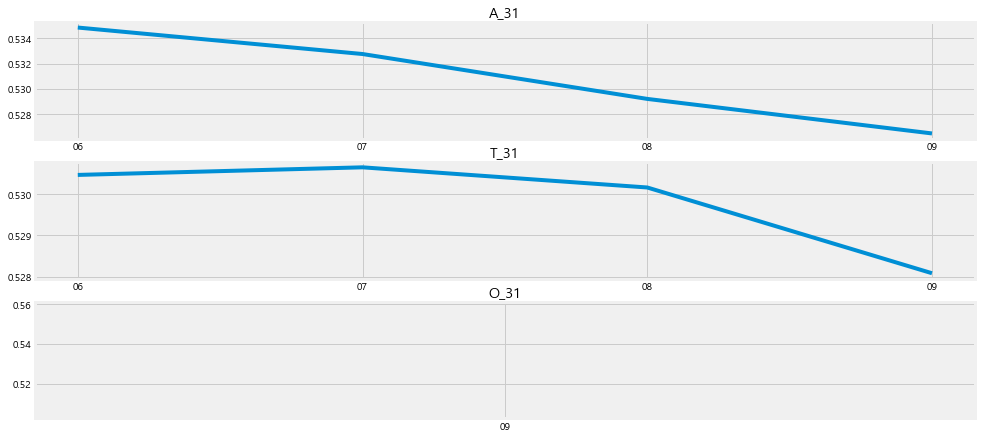

In [196]:
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train['PRODUCT_CODE'].unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['PRODUCT_CODE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

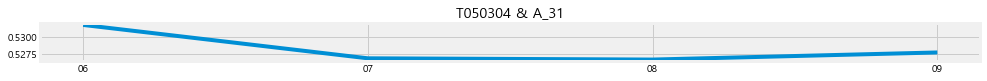

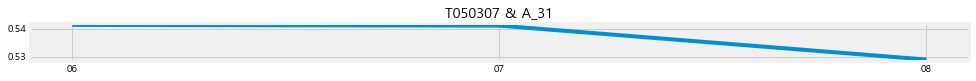

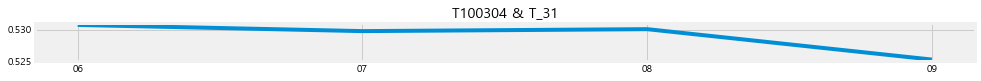

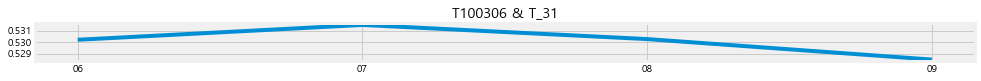

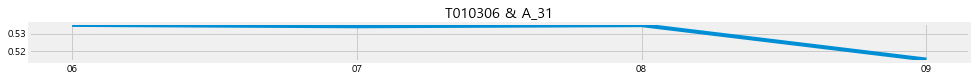

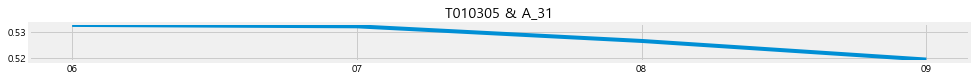

In [197]:
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    for i, c in enumerate(['A_31', 'T_31']): # O_31은 표본이 너무 적어 제외
        tmp = train[(train['PRODUCT_CODE']==c)&(train['LINE']==l)]
        if len(tmp) == 0: continue
        plt.subplot(len(train.LINE.unique())*len(train.PRODUCT_CODE.unique()), 1, i+1)
        tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
        tmp = tmp.groupby('TIMESTAMP').mean()
        plt.plot(tmp.index, tmp['Y_Quality'])
        plt.title(f'{l} & {c}')
    plt.show()

In [198]:
# 월별 영향력이 있어보인다.
train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP']).dt.strftime('%m')
train['TIMESTAMP'] = train['TIMESTAMP'].astype('int64')
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,6,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,6,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,6,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


### X_1 ~ X_2875

In [199]:
len(train.columns)

2881

#### Product Code & Line에 따라 분류했을 경우

In [200]:
train_A1 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050304')]
train_A2 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050307')]
train_A3 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010306')]
train_A4 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010305')]
train_T1 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100304')]
train_T2 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100306')]
train_O1 = train[train['PRODUCT_CODE'] == 'O_31']

In [201]:
print(len(train_A1))
print(len(train_A2))
print(len(train_A3))
print(len(train_A4))
print(len(train_T1))
print(len(train_T2))
print(len(train_O1))

78
42
70
59
172
171
6


In [202]:
def remove_col(df):
    for x in df.columns[6:]:
        if len(df[df[x].isnull()]) > len(df)*0.1:
            df.drop(columns=[x], inplace=True)
    return df

In [203]:
train_A1 = remove_col(train_A1)
train_A2 = remove_col(train_A2)
train_A3 = remove_col(train_A3)
train_A4 = remove_col(train_A4)
train_T1 = remove_col(train_T1)
train_T2 = remove_col(train_T2)
train_O1 = remove_col(train_O1)

In [204]:
print(len(train_A1.columns))
print(len(train_A2.columns))
print(len(train_A3.columns))
print(len(train_A4.columns))
print(len(train_T1.columns))
print(len(train_T2.columns))
print(len(train_O1.columns))

1449
1461
877
877
662
662
656


In [205]:
# 결측값 대체
def nan_replace(df):
    for x in df.columns[6:]:
        for i in df[df[x].isnull()].index:
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==df['TIMESTAMP'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]-1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]+1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue

            df[x][i] = np.mean(df[df['Y_Class']==df['Y_Class'][i]][x])
    return df

In [206]:
train_A1 = nan_replace(train_A1)
train_A2 = nan_replace(train_A2)
train_A3 = nan_replace(train_A3)
train_A4 = nan_replace(train_A4)
train_T1 = nan_replace(train_T1)
train_T2 = nan_replace(train_T2)
train_O1 = nan_replace(train_O1)

In [207]:
train_A1.reset_index(drop=True, inplace=True)
train_A2.reset_index(drop=True, inplace=True)
train_A3.reset_index(drop=True, inplace=True)
train_A4.reset_index(drop=True, inplace=True)
train_T1.reset_index(drop=True, inplace=True)
train_T2.reset_index(drop=True, inplace=True)
train_O1.reset_index(drop=True, inplace=True)

### data split & astype

In [208]:
train_A1.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A2.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A3.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A4.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_T1.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_T2.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_O1.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)

In [212]:
test = test[test.columns[1:]]

test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP']).dt.strftime('%m').astype('int64')
test['LINE'] = test['LINE'].astype('category')
test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')

test.head()

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,9,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Optuna

In [225]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

def lgbm_objective(trial):

    params = {
            "objective": "classifier",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    clf = lightgbm.LGBMClassifier(**params)
    
    f1_list = []
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_train.loc[train_index], y_train.loc[val_index]
        clf.fit(x_trn, y_trn)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='micro'))    
    
    return np.mean(f1_list)

### PCA

In [226]:
# n_list = []
# for train_df in [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train_O1]:
#     pca = PCA()
#     pca.fit(train_df[train_df.columns[6:]])
#     ratio = pca.explained_variance_ratio_

#     df_v = pd.DataFrame(ratio[:5], index=[f'pc{i+1}' for i in range(5)], columns=['pc_ratio'])
    
#     for i in range(5):
#         if sum(df_v['pc_ratio'][:i+1]) > 0.9:
#             n_list.append(i+1)

In [227]:
study_list = []
code_line = [['A_31', 'T100304'], ['A_31', 'T050307'], ['A_31', 'T010306'], ['A_31', 'T010305'], ['T_31', 'T100304'], ['T_31', 'T100306']]

for cl, train_df, n in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2], n_list[:-1]):
    # split
    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    # pca
#     pca = PCA(n_components=n)
#     pc = pca.fit_transform(x_train[x_train.columns[3:]])
#     xtrain_pca = pd.DataFrame(pc, columns = [f'pc{i+1}' for i in range(n)])
    
#     x_train = pd.concat([x_train[x_train.columns[:3]], xtrain_pca], axis=1)
    
    # optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lgbm_objective, n_trials=200, show_progress_bar=True)

    clear_output(wait=True)
    study_list.append(study)

[I 2023-02-04 06:05:54,800] A new study created in memory with name: no-name-801f2612-7d8d-4b6e-9388-3efb6fe03874


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-02-04 06:05:54,960] Trial 0 finished with value: 0.8421848739495799 and parameters: {'max_depth': 23, 'num_leaves': 20, 'learning_rate': 0.39294371674300654, 'n_estimators': 1100, 'colsample_bytree': 0.5464951742219284, 'colsample_bynode': 0.8641600657891908, 'reg_lambda': 0.04343547066295661, 'reg_alpha': 0.16020954148161481, 'min_child_weight': 2, 'min_child_samples': 81}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:05:56,988] Trial 1 finished with value: 0.8363025210084034 and parameters: {'max_depth': 148, 'num_leaves': 2, 'learning_rate': 0.028831094171312997, 'n_estimators': 2000, 'colsample_bytree': 0.9997269864211282, 'colsample_bynode': 0.8471807696635321, 'reg_lambda': 0.030955751861826808, 'reg_alpha': 0.028682572909251195, 'min_child_weight': 4, 'min_child_samples': 14}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:05:58,090] Trial 2 finished with value: 0.8421848739495799 and parameters: {'max_depth': 423, 'num_leaves': 8, '

[I 2023-02-04 06:06:10,376] Trial 20 finished with value: 0.8421848739495799 and parameters: {'max_depth': 59, 'num_leaves': 25, 'learning_rate': 0.9452713519958463, 'n_estimators': 1600, 'colsample_bytree': 0.6328958596877707, 'colsample_bynode': 0.5162293821675141, 'reg_lambda': 0.023639828989557053, 'reg_alpha': 0.4559259883715292, 'min_child_weight': 15, 'min_child_samples': 64}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:06:12,698] Trial 21 finished with value: 0.8421848739495799 and parameters: {'max_depth': 77, 'num_leaves': 125, 'learning_rate': 0.1445195831037855, 'n_estimators': 2400, 'colsample_bytree': 0.5460608421163445, 'colsample_bynode': 0.7058843115244112, 'reg_lambda': 0.28301263257311926, 'reg_alpha': 0.8877316486886037, 'min_child_weight': 13, 'min_child_samples': 18}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:06:12,929] Trial 22 finished with value: 0.8421848739495799 and parameters: {'max_depth': 225, 'num_leaves': 272,

[I 2023-02-04 06:06:24,351] Trial 39 finished with value: 0.8421848739495799 and parameters: {'max_depth': 136, 'num_leaves': 124, 'learning_rate': 0.6095116336733635, 'n_estimators': 2400, 'colsample_bytree': 0.6012188147426326, 'colsample_bynode': 0.8803363206423702, 'reg_lambda': 0.19141053412762435, 'reg_alpha': 0.5376085568441245, 'min_child_weight': 10, 'min_child_samples': 70}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:06:27,152] Trial 40 finished with value: 0.8421848739495799 and parameters: {'max_depth': 90, 'num_leaves': 187, 'learning_rate': 0.6770097074148544, 'n_estimators': 2800, 'colsample_bytree': 0.5655838936123043, 'colsample_bynode': 0.8192996694518486, 'reg_lambda': 0.8320760968016202, 'reg_alpha': 0.030360055903546273, 'min_child_weight': 14, 'min_child_samples': 5}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:06:30,020] Trial 41 finished with value: 0.8421848739495799 and parameters: {'max_depth': 209, 'num_leaves': 257

[I 2023-02-04 06:06:34,857] Trial 59 finished with value: 0.8421848739495799 and parameters: {'max_depth': 360, 'num_leaves': 315, 'learning_rate': 0.36514204679250895, 'n_estimators': 1800, 'colsample_bytree': 0.8290456388409201, 'colsample_bynode': 0.7990106329027362, 'reg_lambda': 0.1039374066712332, 'reg_alpha': 0.06683329079702209, 'min_child_weight': 4, 'min_child_samples': 79}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:06:35,918] Trial 60 finished with value: 0.8245378151260505 and parameters: {'max_depth': 337, 'num_leaves': 700, 'learning_rate': 0.17599382621876536, 'n_estimators': 1100, 'colsample_bytree': 0.9426684661741539, 'colsample_bynode': 0.7225917069332533, 'reg_lambda': 0.028982124220227494, 'reg_alpha': 0.1504408279627113, 'min_child_weight': 5, 'min_child_samples': 55}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:06:37,575] Trial 61 finished with value: 0.8184873949579832 and parameters: {'max_depth': 384, 'num_leaves': 4

[I 2023-02-04 06:07:00,964] Trial 79 finished with value: 0.8421848739495799 and parameters: {'max_depth': 416, 'num_leaves': 992, 'learning_rate': 0.3906193376742815, 'n_estimators': 300, 'colsample_bytree': 0.9758059932559606, 'colsample_bynode': 0.9674998331465264, 'reg_lambda': 0.01310761639106309, 'reg_alpha': 0.18865946922854077, 'min_child_weight': 10, 'min_child_samples': 90}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:07:01,117] Trial 80 finished with value: 0.8421848739495799 and parameters: {'max_depth': 314, 'num_leaves': 131, 'learning_rate': 0.22025743832707162, 'n_estimators': 1200, 'colsample_bytree': 0.9282648949169371, 'colsample_bynode': 0.6448288802768658, 'reg_lambda': 0.2200709552555057, 'reg_alpha': 0.25951091243369934, 'min_child_weight': 10, 'min_child_samples': 76}. Best is trial 0 with value: 0.8421848739495799.
[I 2023-02-04 06:07:01,250] Trial 81 finished with value: 0.8421848739495799 and parameters: {'max_depth': 403, 'num_leaves': 3

[I 2023-02-04 06:07:16,444] Trial 98 finished with value: 0.8421848739495799 and parameters: {'max_depth': 14, 'num_leaves': 5, 'learning_rate': 0.03363214192461134, 'n_estimators': 1900, 'colsample_bytree': 0.6125451114702293, 'colsample_bynode': 0.5150157847156849, 'reg_lambda': 0.03734638353137421, 'reg_alpha': 0.9936217816016231, 'min_child_weight': 12, 'min_child_samples': 52}. Best is trial 90 with value: 0.8478991596638655.
[I 2023-02-04 06:07:17,847] Trial 99 finished with value: 0.8421848739495799 and parameters: {'max_depth': 25, 'num_leaves': 4, 'learning_rate': 0.0625251906985361, 'n_estimators': 1900, 'colsample_bytree': 0.5937290113128678, 'colsample_bynode': 0.8921338462085913, 'reg_lambda': 0.026033179808624785, 'reg_alpha': 0.42147580224376846, 'min_child_weight': 12, 'min_child_samples': 36}. Best is trial 90 with value: 0.8478991596638655.
[I 2023-02-04 06:07:18,778] Trial 100 finished with value: 0.8421848739495799 and parameters: {'max_depth': 500, 'num_leaves': 22

[I 2023-02-04 06:07:37,746] Trial 118 finished with value: 0.8421848739495799 and parameters: {'max_depth': 253, 'num_leaves': 153, 'learning_rate': 0.27542482506443366, 'n_estimators': 1000, 'colsample_bytree': 0.884310910714054, 'colsample_bynode': 0.8408936442290307, 'reg_lambda': 0.015919298305793233, 'reg_alpha': 0.23290948951763019, 'min_child_weight': 10, 'min_child_samples': 85}. Best is trial 90 with value: 0.8478991596638655.
[I 2023-02-04 06:07:37,901] Trial 119 finished with value: 0.8421848739495799 and parameters: {'max_depth': 435, 'num_leaves': 215, 'learning_rate': 0.324687713991598, 'n_estimators': 1200, 'colsample_bytree': 0.9324001032915376, 'colsample_bynode': 0.7589082627605537, 'reg_lambda': 0.012160101043833506, 'reg_alpha': 0.16763540534281446, 'min_child_weight': 8, 'min_child_samples': 94}. Best is trial 90 with value: 0.8478991596638655.
[I 2023-02-04 06:07:38,047] Trial 120 finished with value: 0.8421848739495799 and parameters: {'max_depth': 316, 'num_leav

[I 2023-02-04 06:07:52,648] Trial 137 finished with value: 0.8480672268907563 and parameters: {'max_depth': 348, 'num_leaves': 548, 'learning_rate': 0.07837527813905015, 'n_estimators': 2000, 'colsample_bytree': 0.8344706993552641, 'colsample_bynode': 0.5553266508121382, 'reg_lambda': 0.041525530706585344, 'reg_alpha': 0.04893409812220599, 'min_child_weight': 3, 'min_child_samples': 41}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:07:54,016] Trial 138 finished with value: 0.830420168067227 and parameters: {'max_depth': 373, 'num_leaves': 3, 'learning_rate': 0.1003979195438798, 'n_estimators': 1700, 'colsample_bytree': 0.7719755898250782, 'colsample_bynode': 0.529710878519854, 'reg_lambda': 0.028695679876130052, 'reg_alpha': 0.04525100619265084, 'min_child_weight': 3, 'min_child_samples': 42}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:07:55,889] Trial 139 finished with value: 0.830420168067227 and parameters: {'max_depth': 369, 'num_leaves':

[I 2023-02-04 06:08:20,392] Trial 156 finished with value: 0.8421848739495799 and parameters: {'max_depth': 59, 'num_leaves': 4, 'learning_rate': 0.6985214770918364, 'n_estimators': 2600, 'colsample_bytree': 0.538625149430208, 'colsample_bynode': 0.5182890268327819, 'reg_lambda': 0.06584775993311184, 'reg_alpha': 0.7489906988875858, 'min_child_weight': 15, 'min_child_samples': 33}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:08:21,893] Trial 157 finished with value: 0.8421848739495799 and parameters: {'max_depth': 27, 'num_leaves': 10, 'learning_rate': 0.6877789969669389, 'n_estimators': 2200, 'colsample_bytree': 0.5966197336446474, 'colsample_bynode': 0.8998054704978, 'reg_lambda': 0.1402787223829151, 'reg_alpha': 0.8867478885183188, 'min_child_weight': 15, 'min_child_samples': 41}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:08:24,146] Trial 158 finished with value: 0.8421848739495799 and parameters: {'max_depth': 119, 'num_leaves': 32, 'le

[I 2023-02-04 06:08:38,144] Trial 175 finished with value: 0.8421848739495799 and parameters: {'max_depth': 289, 'num_leaves': 245, 'learning_rate': 0.6224867242500202, 'n_estimators': 1000, 'colsample_bytree': 0.9460397162395723, 'colsample_bynode': 0.9963996415457823, 'reg_lambda': 0.019990258659869538, 'reg_alpha': 0.16377300033419737, 'min_child_weight': 3, 'min_child_samples': 85}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:08:38,270] Trial 176 finished with value: 0.8421848739495799 and parameters: {'max_depth': 234, 'num_leaves': 830, 'learning_rate': 0.4811997997263896, 'n_estimators': 700, 'colsample_bytree': 0.840368226021386, 'colsample_bynode': 0.9617297484575662, 'reg_lambda': 0.014461980534419789, 'reg_alpha': 0.11833698987425344, 'min_child_weight': 10, 'min_child_samples': 88}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:08:38,413] Trial 177 finished with value: 0.8421848739495799 and parameters: {'max_depth': 221, 'num_leave

[I 2023-02-04 06:08:43,562] Trial 194 finished with value: 0.8421848739495799 and parameters: {'max_depth': 480, 'num_leaves': 550, 'learning_rate': 0.025121723936427406, 'n_estimators': 1300, 'colsample_bytree': 0.8313249156090513, 'colsample_bynode': 0.5141551010634764, 'reg_lambda': 0.03148907178803555, 'reg_alpha': 0.0588771950299003, 'min_child_weight': 11, 'min_child_samples': 57}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:08:45,383] Trial 195 finished with value: 0.8421848739495799 and parameters: {'max_depth': 34, 'num_leaves': 605, 'learning_rate': 0.07843653742198133, 'n_estimators': 1900, 'colsample_bytree': 0.808153137393926, 'colsample_bynode': 0.5013010867210073, 'reg_lambda': 0.03621265923692489, 'reg_alpha': 0.09700542208576833, 'min_child_weight': 11, 'min_child_samples': 31}. Best is trial 132 with value: 0.853781512605042.
[I 2023-02-04 06:08:45,556] Trial 196 finished with value: 0.8421848739495799 and parameters: {'max_depth': 19, 'num_leave

In [228]:
def lgbm_objective_O_31(trial):

    params = {
            #"objective": "classifier",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    clf = lightgbm.LGBMClassifier(**params)
    clf.fit(x_train, y_train)

    return f1_score(clf.predict(x_train), y_train, average='micro')

x_train = train_O1.drop(columns=['Y_Class'])
y_train = train_O1['Y_Class']

study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective_O_31, n_trials=50, show_progress_bar=True)

clear_output(wait=True)
study_list.append(study)

[I 2023-02-04 06:08:49,912] A new study created in memory with name: no-name-c3cd8564-8570-4e6c-9b3b-d9c51c2815d6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-02-04 06:08:49,949] Trial 0 finished with value: 0.6666666666666666 and parameters: {'max_depth': 470, 'num_leaves': 9, 'learning_rate': 0.9169346613230496, 'n_estimators': 600, 'colsample_bytree': 0.6086505810248655, 'colsample_bynode': 0.9115809396441878, 'reg_lambda': 0.08296143664674777, 'reg_alpha': 0.046944050135319305, 'min_child_weight': 15, 'min_child_samples': 9}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 06:08:49,983] Trial 1 finished with value: 0.6666666666666666 and parameters: {'max_depth': 512, 'num_leaves': 5, 'learning_rate': 0.18236302576928767, 'n_estimators': 2100, 'colsample_bytree': 0.6777614071869819, 'colsample_bynode': 0.8048611587081638, 'reg_lambda': 0.045191852082745725, 'reg_alpha': 0.40126292388420043, 'min_child_weight': 14, 'min_child_samples': 68}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 06:08:50,021] Trial 2 finished with value: 0.6666666666666666 and parameters: {'max_depth': 232, 'num_leaves': 20, 'l

[I 2023-02-04 06:08:50,635] Trial 20 finished with value: 0.6666666666666666 and parameters: {'max_depth': 282, 'num_leaves': 19, 'learning_rate': 0.508998026690054, 'n_estimators': 500, 'colsample_bytree': 0.8851558177211604, 'colsample_bynode': 0.9931441880056042, 'reg_lambda': 0.020571318162150774, 'reg_alpha': 0.08315079137826546, 'min_child_weight': 7, 'min_child_samples': 15}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 06:08:50,664] Trial 21 finished with value: 0.6666666666666666 and parameters: {'max_depth': 353, 'num_leaves': 82, 'learning_rate': 0.7012780966107534, 'n_estimators': 500, 'colsample_bytree': 0.5826009205698831, 'colsample_bynode': 0.732283687371208, 'reg_lambda': 0.18923391180426138, 'reg_alpha': 0.22444310764244588, 'min_child_weight': 14, 'min_child_samples': 31}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 06:08:50,695] Trial 22 finished with value: 0.6666666666666666 and parameters: {'max_depth': 29, 'num_leaves': 57, 'le

[I 2023-02-04 06:08:51,248] Trial 39 finished with value: 0.6666666666666666 and parameters: {'max_depth': 39, 'num_leaves': 12, 'learning_rate': 0.793694268020499, 'n_estimators': 300, 'colsample_bytree': 0.6574004721012877, 'colsample_bynode': 0.9386903918673154, 'reg_lambda': 0.13144114860923567, 'reg_alpha': 0.2239134616718806, 'min_child_weight': 9, 'min_child_samples': 35}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 06:08:51,273] Trial 40 finished with value: 0.6666666666666666 and parameters: {'max_depth': 63, 'num_leaves': 108, 'learning_rate': 0.9481401948895155, 'n_estimators': 300, 'colsample_bytree': 0.8002581077678962, 'colsample_bynode': 0.8984806595586625, 'reg_lambda': 0.4089873284401526, 'reg_alpha': 0.12800837679186197, 'min_child_weight': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-04 06:08:51,306] Trial 41 finished with value: 0.6666666666666666 and parameters: {'max_depth': 483, 'num_leaves': 42, 'learn

In [229]:
print()
f1_list = []

for study in study_list:
    trial = study.best_trial

    print("  f1_score : {}".format(trial.value))
    f1_list.append(trial.value)
#    print("  Best hyperparameters: ")
#    for key, value in trial.params.items():
#        print("    {}: {}".format(key, value))
print()
print(f'mean_f1 : {np.mean(f1_list)}')


  f1_score : 0.7175
  f1_score : 0.9055555555555556
  f1_score : 0.7142857142857143
  f1_score : 0.593939393939394
  f1_score : 0.8490756302521009
  f1_score : 0.853781512605042
  f1_score : 0.6666666666666666

mean_f1 : 0.7572577819006392


In [230]:
for study in study_list:
    print(study.best_params)
    print()

{'max_depth': 318, 'num_leaves': 472, 'learning_rate': 0.22503906024751974, 'n_estimators': 1100, 'colsample_bytree': 0.5181754671967488, 'colsample_bynode': 0.8545408777260162, 'reg_lambda': 0.06203722457064303, 'reg_alpha': 0.012356450863621379, 'min_child_weight': 9, 'min_child_samples': 7}

{'max_depth': 404, 'num_leaves': 27, 'learning_rate': 0.49323896299493764, 'n_estimators': 400, 'colsample_bytree': 0.6499440185491085, 'colsample_bynode': 0.8735629402938402, 'reg_lambda': 0.07515955278747456, 'reg_alpha': 0.4147367034267318, 'min_child_weight': 2, 'min_child_samples': 5}

{'max_depth': 243, 'num_leaves': 304, 'learning_rate': 0.1960332778793628, 'n_estimators': 2900, 'colsample_bytree': 0.9634115627069231, 'colsample_bynode': 0.5300959211368912, 'reg_lambda': 0.07402450271884667, 'reg_alpha': 0.020928462889057666, 'min_child_weight': 3, 'min_child_samples': 9}

{'max_depth': 31, 'num_leaves': 194, 'learning_rate': 0.3838378970003029, 'n_estimators': 1400, 'colsample_bytree': 0

In [231]:
code_line.append(['O_31'])
for cl, train_df, study in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train_O1], study_list):

    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    if cl[0] == 'O_31':
        test_cl = test[test['PRODUCT_CODE'] == cl[0]]
    else:
        test_cl = test[(test['PRODUCT_CODE'] == cl[0]) & (test['LINE'] == cl[1])]
    
    if len(test_cl) == 0:
        continue
    test_cl = test_cl[x_train.columns]

    # pca
#     pca = PCA(n_components=n)
#     pc = pca.fit_transform(x_train[x_train.columns[3:]])
#     xtrain_pca = pd.DataFrame(pc, columns = [f'pc{i+1}' for i in range(n)])
    
#     pc = pca.transform(test_cl[test_cl.columns[3:]])
#     test_pca = pd.DataFrame(pc, columns = [f'pc{i+1}' for i in range(n)])
#     test_pca.head()
    
#     x_train = pd.concat([x_train[x_train.columns[:3]], xtrain_pca], axis=1)
#     test_cl = pd.concat([test_cl[test_cl.columns[:3]], test_pca], axis=1)    
    
    # lightgbm
    clf = lightgbm.LGBMClassifier(**study.best_params)
    clf.fit(x_train, y_train, verbose=0)
    pred = clf.predict(test_cl)
    for i, idx in enumerate(test_cl.index):
        subm['Y_Class'][idx] = pred[i]

In [232]:
subm.Y_Class.value_counts()

1    270
0     33
2      7
Name: Y_Class, dtype: int64

In [ ]:
###Y_Quality를 예측->proba로 이용해보자

In [233]:
subm.to_csv('submission/submission12.csv', index=False) # optuna200_lgbm_micro_cl_devision_yclass